In [406]:
   
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#from tensorflow.python.framework import ops from cnn_utils import *

from math import pi
import itertools
import time

%matplotlib inline

with tf.Session() as sess:
    hello = tf.constant('Hello, TensorFlow!')
    print(sess.run(hello))


b'Hello, TensorFlow!'


In [407]:

np.random.seed(seed=123)

class Vertex:
    """a polar coordinate vertex of unit length"""
    def __init__(self, index):
        self.index = index
        if(index == 0):
            self.theta = tf.constant([0.0], dtype=tf.float64, name = "theta" + str(index))
            self.phi = tf.constant([0.0], dtype=tf.float64, name = "phi" + str(index))
        else:   
            self.theta = tf.get_variable("theta" + str(index), [1] , dtype=tf.float64, 
                                     initializer=tf.constant_initializer(np.random.random_sample() * pi))
            if(index == 1):
                self.phi = tf.constant([0.0], dtype=tf.float64, name = "phi" + str(index))
            else:
                self.phi = tf.get_variable("phi" + str(index), [1] , dtype=tf.float64,
                                   initializer=tf.constant_initializer(np.random.random_sample() * 2 * pi))
        #print( index )
        #print(self.theta)
        #print(self.phi)
        sin_theta = tf.sin(self.theta)
        self.x = tf.multiply(sin_theta, tf.cos(self.phi) , name='x' + str(self.index))
        self.y = tf.multiply(sin_theta, tf.sin(self.phi) , name='y' + str(self.index))
        self.z = tf.cos(self.theta, name='z' + str(self.index))
        self.xyz = tf.concat([self.x, self.y, self.z], axis=0)


def make_vertextes( n_vertexes ):
    print('make_vertextes')
    vertexes = []
    for i in range(n_vertexes):
        vertexes.append( Vertex(i) )
    return vertexes

def make_pairs( vertexes ):
    print('make Pairs Inverse Distance')
    list = []
    for pair in itertools.combinations(vertexes, 2):
        list.append( 1 / tf.norm(pair[0].xyz-pair[1].xyz))
    return tf.add_n(list)    



In [408]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from sklearn import preprocessing

from pythreejs import *
import numpy as np
from IPython.display import display

def make_face_normals(verts,simplices):
    print(verts)
    print(simplices)
    face_normals = np.zeros((simplices.shape[0],3))
    for i in range(simplices.shape[0]):
        v = face_normals[i]
        for vertex_index in simplices[i]:
            #print(vertex_index)
            v += verts[vertex_index]
            
    face_normals = preprocessing.normalize(face_normals, norm='l2')   
    print(face_normals) 
    
    tuples=[]
    for i in range(face_normals.shape[0]):
        tuples.append((face_normals[i],i))
    return tuples    


def fix_simplex_normals(verts, simplices):
    #print('fix_simplex_normals')
    base = 1
    left = 0
    right = 2
    for face in simplices:
        vA = verts[ face[left] ];
        vB = verts[ face[base] ];
        vC = verts[ face[right] ];

        cb = vC - vB
        ab = vA - vB
        cross = np.cross( cb, ab )
        dot = np.dot( vA, cross)
        if dot < 0:
            #print( face )
            tmp  = face[left]
            face[left] = face[right]
            face[right] = tmp
            #print( dot )
            #print( face )
    return None

def make_vert_spheres(verts):
    spheres = []
    for v in verts:
        sphereGeom = SphereGeometry( radius = 0.03)
        sphereMesh = Mesh(geometry=sphereGeom, material = LambertMaterial(color='#aaaaaa',transparent=True, opacity=0.75))
        sphereMesh.position = v.tolist()
        spheres.append(sphereMesh)
    return spheres    


def makeMeshes(verts, simplices):
    #fix_simplex_normals(verts, simplices)
    fix_simplex_normals(verts, simplices)
    
    # https://github.com/jovyan/pythreejs
    cubeGeometry = PlainGeometry(vertices=verts, faces=simplices)   
    # , faceNormals=make_face_normals(pos,simplices)
    
    #,transparent=True, opacity=0.7, side='DoubleSide'
    myobjectCube = Mesh(geometry=cubeGeometry, material = LambertMaterial(color='#888888'))
    myobjectCube.material.wireframe = True
    camera = PerspectiveCamera(position=[-0.5, 6, -0.5], fov=25, aspect=1.0,
                          children=[DirectionalLight(color='#aaaaaa', position=[20, 20, 30], intensity=4)])
    spheres = make_vert_spheres(verts)
    sceneCube = Scene(children=[myobjectCube, AmbientLight(color='#aaaaaa', intensity=4)]+spheres)

    renderer = Renderer(camera=camera, background='black', background_opacity=1,
                            scene = sceneCube, controls=[OrbitControls(controlling=camera)], width='800',height='800')
   
    return renderer

In [482]:
n_vertexes = 11 # 12 42

learning_rate = 6/(n_vertexes**2) 

start_time = time.time()

tf.reset_default_graph()
vertextes = make_vertextes(n_vertexes)
potential = make_pairs(vertextes)

multiplier = 1.02
learning_rate_placeholder = tf.placeholder(tf.float32, [], name='learning_rate')
print('make optimizer') 
optimizer = tf.train.GradientDescentOptimizer( learning_rate=learning_rate_placeholder ).minimize(potential)

#print([v.xyz for v in vertextes])
allPositions = tf.stack([v.xyz for v in vertextes])

NUM_THREADS = 2
 
print('start session') 
with tf.Session(config=tf.ConfigProto( intra_op_parallelism_threads=NUM_THREADS)) as sess:
    sess.run(tf.global_variables_initializer())
    last_p = 1e6
    last_was_equal = False
    for i in range(10000):
        if(i % 10 == 0):
            _ , p = sess.run([optimizer, potential], feed_dict={learning_rate_placeholder: learning_rate} )
            if(i % 200 == 0):
                print( str(i) + ' ' + "{0:.16f},  ".format(p), end='')
            #if(i % 50 == 0):
            #    print( str(i) + ' ' + "{0:.8f}".format(p) + ' learning_rate = ' + 
            #          str( learning_rate) + ' multiplier = ' + str(multiplier) )
            #print( p - last_p )
            if abs(p - last_p) < 1e-15:
                if last_was_equal:
                    print('early stop')
                    break
                else:
                    last_was_equal = True
            else:
                last_was_equal = False
            #if( p < last_p ):
            #    learning_rate *= multiplier
            #else:
            #    learning_rate = max(1e-3, learning_rate/8)
            #    multiplier = 1 + (multiplier-1)/2
            last_p = p;
        else:
            sess.run( optimizer, feed_dict={learning_rate_placeholder: learning_rate} )  
    
    elapsed_time = time.time() - start_time
    print( str(elapsed_time)  + ' sec')
    print( str(i) + ' epochs' )
    
    verts = sess.run(allPositions, feed_dict={learning_rate_placeholder: learning_rate})    
    #print(verts)
    
    

make_vertextes
make Pairs Inverse Distance
make optimizer
start session
0 130.3497965923545507,  200 40.6044636646904635,  400 40.5984057813138719,  600 40.5981599856807946,  800 40.5978520936401495,  1000 40.5973747237727736,  1200 40.5968626471561436,  1400 40.5965763380727296,  1600 40.5964995782176956,  1800 40.5964878273315648,  2000 40.5964862687656449,  2200 40.5964859616348548,  2400 40.5964856462948518,  2600 40.5964853167508650,  2800 40.5964849672755577,  3000 40.5964845925951465,  3200 40.5964841879752285,  3400 40.5964837492137249,  3600 40.5964832725671627,  3800 40.5964827546463169,  4000 40.5964821923165289,  4200 40.5964815826275185,  4400 40.5964809227850694,  4600 40.5964802101644580,  4800 40.5964794423600779,  5000 40.5964786172633723,  5200 40.5964777331629847,  5400 40.5964767888633418,  5600 40.5964757838187111,  5800 40.5964747182808878,  6000 40.5964736032391613,  6200 40.5964733909369571,  6400 40.5964732375332886,  6600 40.5964730773899163,  6800 40.59647291

In [481]:

hull = ConvexHull(verts)

display(makeMeshes(verts, hull.simplices))

Renderer(background_opacity=1.0, camera=PerspectiveCamera(aspect=1.0, children=[DirectionalLight(color='#aaaaaa', intensity=4.0, position=[20.0, 20.0, 30.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0])], fov=25.0, position=[-0.5, 6.0, -0.5], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), controls=[OrbitControls(controlling=PerspectiveCamera(aspect=1.0, children=[DirectionalLight(color='#aaaaaa', intensity=4.0, position=[20.0, 20.0, 30.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0])], fov=25.0, position=[-0.5, 6.0, -0.5], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), target=[0.0, 0.0, 0.0])], effect=None, height='800', scene=Scene(children=[Mesh(geometry=PlainGeometry(faces=array([[ 1,  5, 10],
       [ 8,  0,  4],
       [ 2,  5,  1],
       [ 6,  0,  8],
       [ 5,  2,  6],
       [ 6,  2,  0],
       [ 3,  2,  1],
       [ 3,  4,  0],
       [ 0,  2,  3],
       [ 8,  4,  9],
       [ 4,  3,  9],
       [ 1, 10,  9],
       [ 9,  3,  1],
       [ 7, 10,  5],
       [ 5,  6,  7],
       [ 7,  6,  8],
       [ 8,  9,  7],
       [ 7,  9, 10]], dtype=uint32), vertices=array([[ 0.        ,  0.        ,  1.        ],
       [-0.87021053, -0.        , -0.49268004],
       [-0.68665075,  0.57243377,  0.44814095],
       [-0.77842468, -0.54302406,  0.31492832],
       [ 0.1469274 , -0.89054424,  0.43051517],
       [-0.14074638,  0.91012764, -0.38968983],
       [ 0.48266605,  0.75547469,  0.44304794],
       [ 0.82171124,  0.25740063, -0.50846392],
       [ 0.9116196 , -0.2673355 ,  0.31222016],
       [ 0.12795968, -0.8241716 , -0.55169505],
       [-0.01733994,  0.04023007, -0.99903995]], dtype=float32)), material=LambertMaterial(color='#888888', envMap=None, lightMap=None, map=None, specularMap=None, wireframe=True), position=[0.0, 0.0, 0.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), AmbientLight(color='#aaaaaa', position=[0.0, 0.0, 0.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#aaaaaa', envMap=None, lightMap=None, map=None, opacity=0.75, specularMap=None, transparent=True), position=[0.0, 0.0, 1.0], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#aaaaaa', envMap=None, lightMap=None, map=None, opacity=0.75, specularMap=None, transparent=True), position=[-0.870210536220559, -0.0, -0.4926800408487512], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#aaaaaa', envMap=None, lightMap=None, map=None, opacity=0.75, specularMap=None, transparent=True), position=[-0.6866507307636817, 0.5724337964776584, 0.44814096285864874], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#aaaaaa', envMap=None, lightMap=None, map=None, opacity=0.75, specularMap=None, transparent=True), position=[-0.7784247046393127, -0.5430240608759341, 0.31492832282443], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#aaaaaa', envMap=None, lightMap=None, map=None, opacity=0.75, specularMap=None, transparent=True), position=[0.14692740866115178, -0.8905442291614, 0.430515171035176], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#aaaaaa', envMap=None, lightMap=None, map=None, opacity=0.75, specularMap=None, transparent=True), position=[-0.14074638096591735, 0.9101276263833081, -0.3896898252955575], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#aaaaaa', envMap=None, lightMap=None, map=None, opacity=0.75, specularMap=None, transparent=True), position=[0.48266604640754635, 0.7554746846426453, 0.4430479528328778], scale=[1.0, 1.0, 1.0], up=[0.0, 1.0, 0.0]), Mesh(geometry=SphereGeometry(radius=0.03), material=LambertMaterial(color='#aaaaaa', envMap=None, lightMap=None, map=None,

In [478]:


def add_ordered(set, index1, index2):
    if index1 < index2:
        set.add((index1, index2))
    else:
        set.add((index2, index1))

def get_edges(simplexes):
    edges = set()
    for s in simplexes:
        add_ordered(edges, s[0], s[1])
        add_ordered(edges, s[1], s[2])
        add_ordered(edges, s[0], s[2])
    return list(edges)    

class EdgeGroup:
    """all edges that are the same distance"""
    def __init__(self, distance):
        self.distance = distance
        self.count = 1
        
    def __str__(self):
        return str(self.distance) + ':' + str(self.count)


def make_surface_edge_groups(verts, simplexes, epsilon):
    groups = []
    edges = get_edges(simplexes)
    for e in edges:
        distance = np.linalg.norm(verts[e[0]] - verts[e[1]])
        found = False
        for g in groups:
            if abs(g[0] - distance) < epsilon:
                g[1]+=1
                found=True
                break
        if not found:      
            groups.append( [distance,1] ) 
                                 
    return list(groups)
    
epsilon = 1e-6    
groups = make_surface_edge_groups(verts, hull.simplices, epsilon) 
print(groups)

[[1.0583029381012752, 1], [1.2785268190017112, 1], [1.1751553441879716, 1], [1.1665778094684034, 1], [0.9958015619724182, 1], [1.3019902706673028, 1], [1.0639798880971416, 1], [0.99520025088354636, 1], [1.1163144750359373, 1], [1.1269204514106823, 1], [1.175633137022337, 1], [1.291219374707699, 1], [1.1127184300571351, 1], [1.0512529819454588, 1], [1.1838262022082031, 1], [0.99320116909731604, 1], [1.0480047336848441, 1], [1.1307179955744109, 1], [0.98324032035703535, 1], [0.98593888503530203, 1], [1.0724454508383958, 1], [0.97777434023551524, 1], [1.055195373042356, 1], [0.97807657027764772, 1], [1.2868894648441236, 1], [0.99300515140067258, 1], [1.1666024457104691, 1]]


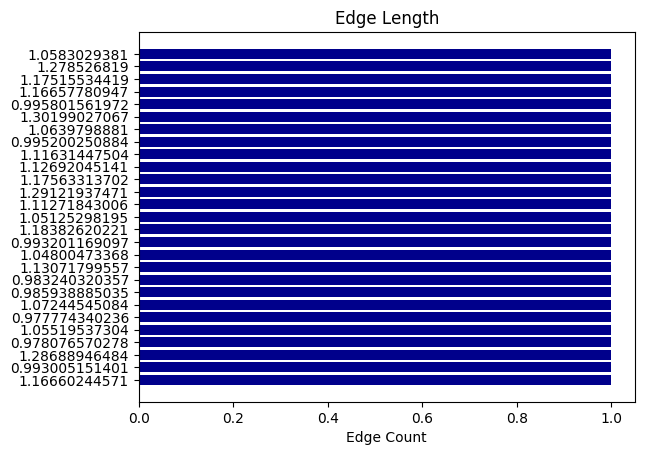

In [479]:
import matplotlib.pyplot as plt
import numpy as np


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = [group[0] for group in groups]
y_pos = np.arange(len(people))
performance = [group[1] for group in groups]

ax.barh(y_pos, performance, align='center',
        color='darkblue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Edge Count')
ax.set_title('Edge Length')

plt.show()

Todo:
1. fix face normals, https://github.com/mrdoob/three.js/blob/dev/src/core/Geometry.js computeFaceNormals
cubeGeometry.faceNormals

2. edge stats bar chart
4. transparent faces
5. edge color groups
5. graph
    1. e f v
    2. potential per ?
    3. groups
    4. periodic table of groups


## 12 Vertexes
![exampleOutput.png](exampleOutput.png)


## 32 Vertexes
![exampleOutput-32.png](exampleOutput-32.png)


In [412]:
#cubeGeometry.faceNormals.__class__
